## 5. Prediction and Evaluation using Prophet

**Overview:**
- In this notebook, we will build a predictive model using the Prophet library developed by Facebook. We will examine the usefulness of automated features and the potential for accuracy improvement through parameter tuning.

**Reasons for choosing Prophet:**
Prophet is based on a Generalized Additive Model (GAM) and has the following features:
- **Automation and Simplicity**: Even without extensive knowledge of complex time series analysis, it can automatically detect trends, seasonality, and holiday effects, allowing for the relatively easy construction of highly accurate models.
- **Interpretability**: The model can be decomposed into components such as "trend," "seasonality," and "holiday effects," making it easy to understand the basis of prediction results and aiding in grasping data characteristics.
- **Flexible Customization**: Custom seasonality, holidays, and external variables can be easily added, making it simple to incorporate domain knowledge into the model.

Based on these features, it was determined to be useful for both rapid model construction and deep data understanding, leading to its adoption.

### 5-1. Preparation: Libraries, Data, Common Settings

In [1]:
# Import libraries
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

# Handle rendering errors
import plotly.io as pio
pio.renderers.default = "vscode" 

# Optuna related
import optuna
from sklearn.metrics import mean_squared_error

# Import common modules
from src.data_utils import load_timeseries_data
from src.evaluation_utils import evaluate_forecast
from src.forecast_utils import sliding_window_forecast
from src.plot_utils import plot_forecast_vs_actual

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['font.family'] = 'Meiryo' # For Windows

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)

print("Data shape:", df.shape)
print("Data period:", df.index.min(), "to", df.index.max())
df.head()

Data shape: (39408, 2)
Data period: 2023-01-01 00:00:00 to 2025-03-31 23:30:00


,solar_gen_mw,e_demand_mw
datetime,,
2023-01-01 00:00:00,0,29870
2023-01-01 00:30:00,0,28640
2023-01-01 01:00:00,0,27560
2023-01-01 01:30:00,0,27240
2023-01-01 02:00:00,0,26650


In [3]:
# In relation to the method of shifting y in 07_lightGBM.ipynb and 08_gru_forecast.ipynb
# Shift one day of data forward.
df = df[48:]
df.head()

,solar_gen_mw,e_demand_mw
datetime,,
2023-01-02 00:00:00,0,26500
2023-01-02 00:30:00,0,25590
2023-01-02 01:00:00,0,24850
2023-01-02 01:30:00,0,24460
2023-01-02 02:00:00,0,24430


**Definition of sliding_window Function, Evaluation Functions, and Common Settings**

For time series cross-validation, the sliding window function `src/forecast_utils.py sliding_window_forecast` and the function `src/evaluation_utils.py evaluate_forecast` for calculating evaluation metrics (MAE, RMSE, MASE) are used.

**MASE Seasonality**:
    * Power generation (solar_gen_mw): seasonal period $m=48$ (daily period)
    * Consumption (e_demand_mw): seasonal period $m=336$ (weekly period)

In [4]:
# Common parameters for sliding window
TRAIN_LENGTH = 2880  # 60 days * 48 points/day
TEST_LENGTH = 48     # 1 day * 48 points/day
SLIDE_COUNT = 30     # 30 days
STRIDE = 48          # 1 day (non-overlapping)

In [5]:
# Wrapper function for Prophet model
def prophet_model_wrapper(train_data, test_steps, **model_params):
    # Prophet requires column names to be 'ds' and 'y'
    prophet_df = train_data.reset_index()
    prophet_df.columns = ['ds', 'y']
    
    # Model definition and training
    model = Prophet(**model_params)
    model.fit(prophet_df)
    
    # Create a DataFrame for predictions
    future = model.make_future_dataframe(periods=test_steps, freq='30T')
    forecast = model.predict(future)
    
    # Return predicted values for the forecast period, the model, and the forecast result DataFrame
    return forecast['yhat'].values[-test_steps:], model, forecast

# Initial model parameters
initial_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True
}

### 5-2. Baseline Prediction with Default Settings

#### 5-2-1. Executing Predictions (Generation/Consumption)

In [6]:
# Forecast of power generation and consumption
print("Prophet: Starting power generation forecast...")
preds_df_gen, models_gen, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=initial_model_params
)
print("Done.")

print("Prophet: Starting consumption forecast...")
preds_df_con, models_con, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=initial_model_params
)
print("Done.")

Prophet: Starting power generation forecast...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

17:46:02 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing
17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:05 - cmdstanpy - INFO - Chain [1] done processing
17:46:05 - cmdstanpy - INFO - Chain [1] start processing
17:46:06 - cmdstanpy - INFO - Chain [1] done processing
17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:06 - cmdstanpy - INFO - Chain [1] done processing
17:46:07 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:09 - cmdstanpy - INFO - Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
17:46:10 - cmdstanpy - INFO - Chain [1] start processing
17:46:10 - cmdstanpy - INFO - Chain [1]

Done.
Prophet: Starting consumption forecast...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

17:46:29 - cmdstanpy - INFO - Chain [1] start processing
17:46:30 - cmdstanpy - INFO - Chain [1] done processing
17:46:30 - cmdstanpy - INFO - Chain [1] start processing
17:46:31 - cmdstanpy - INFO - Chain [1] done processing
17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing
17:46:33 - cmdstanpy - INFO - Chain [1] start processing
17:46:34 - cmdstanpy - INFO - Chain [1] done processing
17:46:35 - cmdstanpy - INFO - Chain [1] start processing
17:46:36 - cmdstanpy - INFO - Chain [1] done processing
17:46:36 - cmdstanpy - INFO - Chain [1] start processing
17:46:37 - cmdstanpy - INFO - Chain [1] done processing
17:46:38 - cmdstanpy - INFO - Chain [1] start processing
17:46:38 - cmdstanpy - INFO - Chain [1] done processing
17:46:39 - cmdstanpy - INFO - Chain [1] start processing
17:46:40 - cmdstanpy - INFO - Chain [1] done processing
17:46:40 - cmdstanpy - INFO - Chain [1] start processing
17:46:41 - cmdstanpy - INFO - Chain [1]

Done.


#### 5-2-2. Evaluation and Visualization of Results

In [7]:
# Create evaluation results
# Use initial training data for MASE calculation
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
metrics_gen = evaluate_forecast(preds_df_gen['true'], preds_df_gen['pred'], y_train_gen.values, m=48)

y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
metrics_con = evaluate_forecast(preds_df_con['true'], preds_df_con['pred'], y_train_con.values, m=336)

# Display evaluation results
print("Prophet Evaluation Results (30 Days) ")
prophet_summary = pd.DataFrame({
    'generation': metrics_gen,
    'consumption': metrics_con
})
print(prophet_summary)

Prophet Evaluation Results (30 Days) 
       generation  consumption
MAE   1772.373970  2323.211371
RMSE  2436.543373  2888.244610
MASE     2.408882     0.735676


**Evaluation Results (Default)**
|      | generation  | consumption |
|------|------------:|------------:|
| MAE  | 1772.37 | 2323.21 |
| RMSE | 2436.54 | 2888.24 |
| MASE | 2.409 | 0.736 |

**Observations:**
- **Generation Forecast**: MASE was high at 2.41, resulting in lower accuracy than the Holt-Winters method (2.26) and SARIMAX (1.90). The default settings failed to capture the steep intra-day fluctuation patterns inherent in solar power generation.
- **Consumption Forecast**: MASE is 0.74, below 1.0, but it did not surpass other baseline models such as Holt-Winters (0.53) and SARIMAX (0.54).

With its default settings, Prophet did not demonstrate performance superior to other baseline models. In the next step, we will perform parameter tuning, which is Prophet's strength, aiming to improve accuracy.

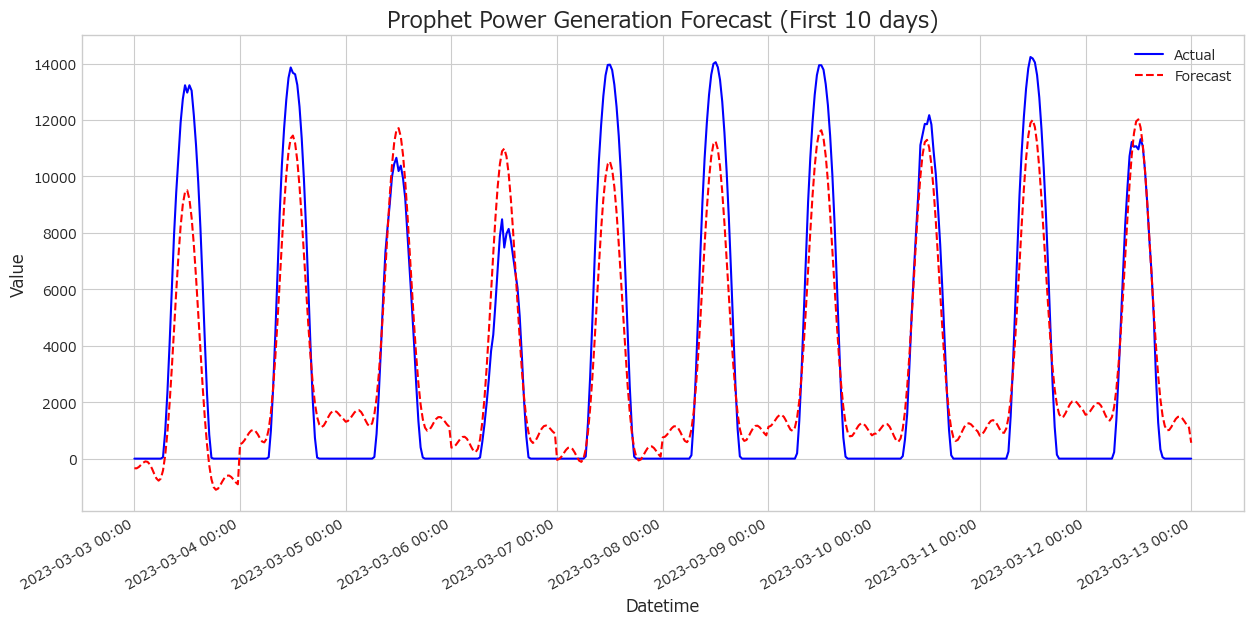

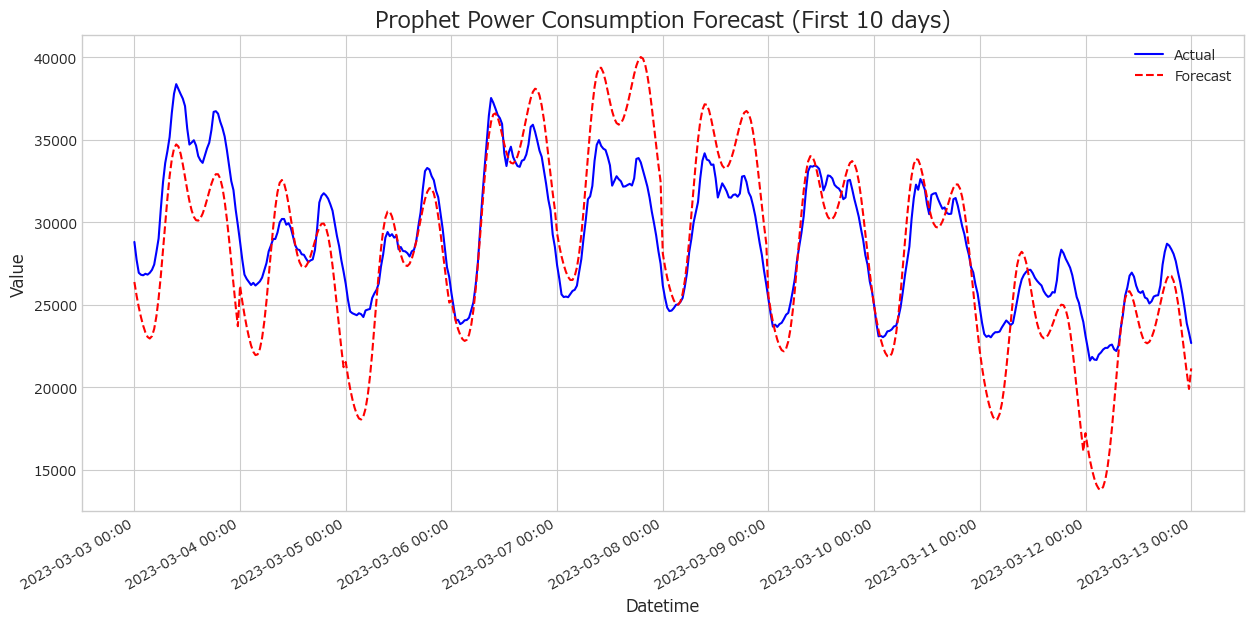

In [8]:
# Execute Visualization
# Power Generation
plot_forecast_vs_actual(preds_df_gen, 'Prophet Power Generation Forecast (First 10 days)', days_to_show=10)
# Consumption
plot_forecast_vs_actual(preds_df_con, 'Prophet Power Consumption Forecast (First 10 days)', days_to_show=10)

#### 5-2-3. Model Interpretation by Component Decomposition

Using Prophet's `plot_components` to display the decomposition of trend, seasonality, and residuals, deepening understanding of the data.

The full period is used for observation and understanding, but to prevent data leakage, refrain from extracting numerical values from here for use elsewhere.

In [9]:
# Create a new df for Prophet for the entire period for long-term decomposition
df_prophet = df.copy()

df_gen = df_prophet['solar_gen_mw'].reset_index()
df_gen.columns = ['ds', 'y']

df_con = df_prophet['e_demand_mw'].reset_index()
df_con.columns = ['ds', 'y']

17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing


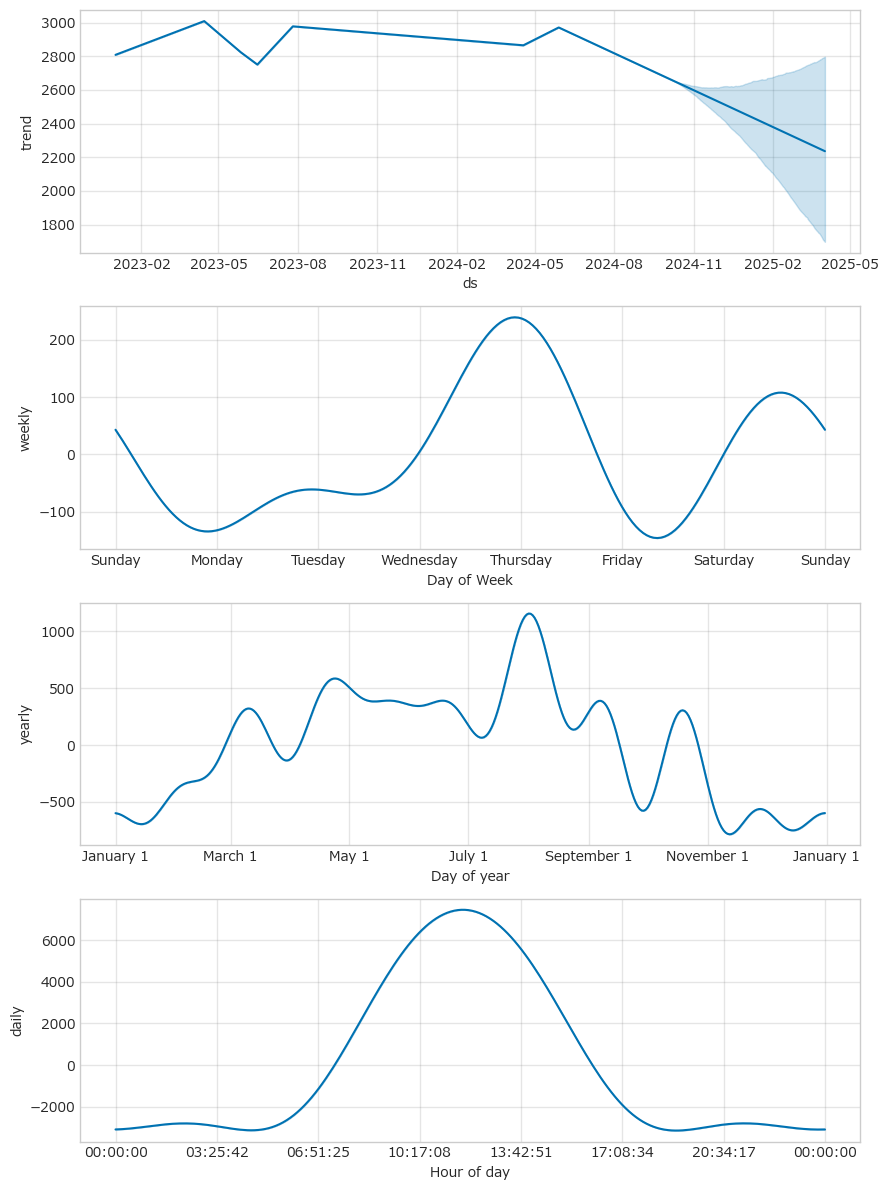

In [10]:
# Generation component decomposition
# Set period
points_per_day = 48
forecast_length = int(48 * 180 ) # Approx. half a year
train_length = int(39408 - forecast_length)   # 30768 Approx. 21 months

# Slice data
df_recent = df_gen[0:train_length]

# Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)
model.fit(df_recent)

# Predict the next half year
future = model.make_future_dataframe(periods=forecast_length, freq='30min')
forecast = model.predict(future)

# Display component decomposition graph
fig = model.plot_components(forecast)
plt.show()

17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing


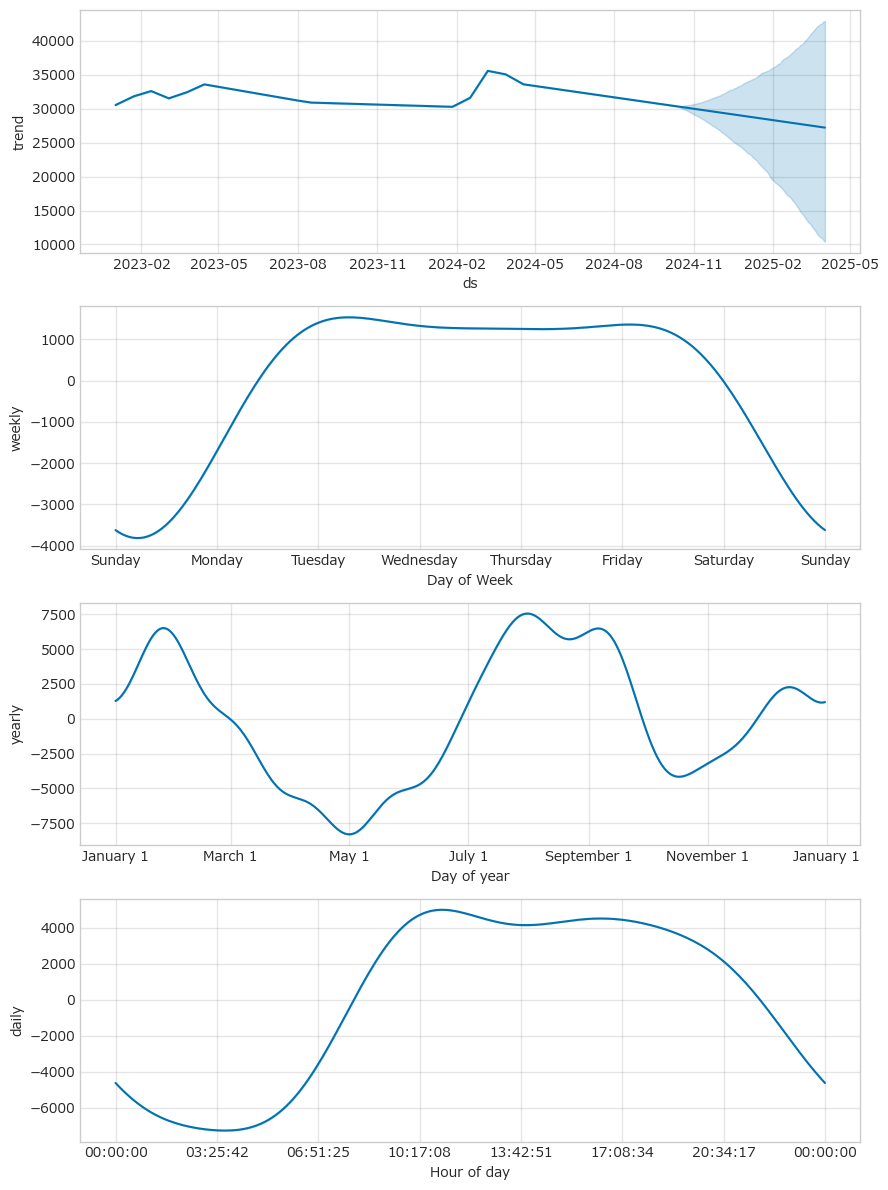

In [11]:
# Demand Decomposition

# Data Slicing
df_recent = df_con[0:train_length]

# Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,   
)
model.fit(df_recent)

# Predict the next six months
future = model.make_future_dataframe(periods=forecast_length, freq='30min')
forecast = model.predict(future)

# Display Component Decomposition Plot
fig = model.plot_components(forecast)
plt.show()

**Observations**
- The results were largely similar to the annual, weekly, and daily changes observed in the first half of 03_Hierarchical_Pattern_Analysis_and_Data_Insight.

- Power generation's weekly (by day of the week) fluctuations were small in amplitude; annual (monthly) levels were high in summer, with a slight slowdown in increase during the rainy season (e.g., June); and daily patterns are largely considered to be determined by the amount of sunlight.

- Demand (consumption) shows annual patterns with high heating and cooling demand in summer and winter; weekly patterns starting somewhat slowly on Monday, peaking on weekdays, and declining towards the weekend; and daily patterns sharply rising from morning, plateauing from noon to afternoon, and decreasing through the night until midnight.  

- Both align with intuitively predictable patterns, making them highly plausible; moreover, while monthly averages, for example, would result in a single value, this decomposition allows us to discern changes from the beginning to the end of each month.

### 5-3. Hyperparameter Optimization using Optuna

- Prophet's prediction accuracy highly depends on parameter settings. In this section, we will focus on tuning two important parameters: `seasonality_prior_scale`, which controls the flexibility of seasonality, and `changepoint_prior_scale`, which controls the flexibility of trend changepoints.

### 5-3-1. Tuning of Power Generation Forecasting

In [12]:
# Define Optuna objective function
# Fix the data for tuning (first 60 days = TRAIN_LENGTH)
tune_df_gen = df[['solar_gen_mw']].iloc[:TRAIN_LENGTH].reset_index()
tune_df_gen.columns = ['ds', 'y']

def objective_gen(trial):
    # Define the range of parameters to tune
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'daily_seasonality': True,
        'weekly_seasonality': True,
        'yearly_seasonality': True
    }
    
    # Model definition
    model = Prophet(**params)
    model.fit(tune_df_gen)
    
    # Perform cross-validation within TRAIN_LENGTH
    # initial: 48 days, period: 1 day, horizon: 1 day
    # This performs 12 validations starting from day 48
    df_cv = cross_validation(
        model,
        initial='48 days', # 48 days
        period='1 day',  # 1 day
        horizon='1 day', # 1 day
        disable_tqdm=True # Suppress tqdm output
    )
    
    # Evaluation (RMSE)
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]

# Execute optimization with Optuna
print("Starting Optuna hyperparameter tuning (power generation)...")
optuna.logging.set_verbosity(optuna.logging.WARNING) # Suppress Optuna log output
study_gen = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_gen.optimize(objective_gen, n_trials=30, show_progress_bar=False)

# Display results
print("\nOptuna Tuning Results (power generation)")
print(f"Number of trials: {len(study_gen.trials)}")
print(f"Optimal parameters: {study_gen.best_params}")
print(f"Minimum RMSE: {study_gen.best_value}")

# Store best_params for use in subsequent cells
best_params_gen = study_gen.best_params

Starting Optuna hyperparameter tuning (power generation)...


17:48:03 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:04 - cmdstanpy - INFO - Chain [1] start processing
17:48:04 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:05 - cmdstanpy - INFO - Chain [1] start processing
17:48:05 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:06 - cmdstanpy - INFO - Chain [1] done processing
17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done pro


Optuna Tuning Results (power generation)
Number of trials: 30
Optimal parameters: {'changepoint_prior_scale': 0.03519174873408796, 'seasonality_prior_scale': 2.9081465894110603}
Minimum RMSE: 851.8145565809785


#### 5-3-2. Power Generation Forecasting and Evaluation Using the Tuned Model

Re-running 30-day power generation forecast using Optuna-tuned parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

17:51:22 - cmdstanpy - INFO - Chain [1] start processing
17:51:22 - cmdstanpy - INFO - Chain [1] done processing
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
17:51:24 - cmdstanpy - INFO - Chain [1] start processing
17:51:24 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:25 - cmdstanpy - INFO - Chain [1] done processing
17:51:26 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing
17:51:27 - cmdstanpy - INFO - Chain [1] start processing
17:51:27 - cmdstanpy - INFO - Chain [1] done processing
17:51:28 - cmdstanpy - INFO - Chain [1] start processing
17:51:28 - cmdstanpy - INFO - Chain [1] done processing
17:51:29 - cmdstanpy - INFO - Chain [1] start processing
17:51:29 - cmdstanpy - INFO - Chain [1]

Done.
Comparison of evaluation metrics (Power Generation Forecast - 30 Days)
          Initial        Tuned
MAE   1772.373970  1730.195857
RMSE  2436.543373  2446.802209
MASE     2.408882     2.351556


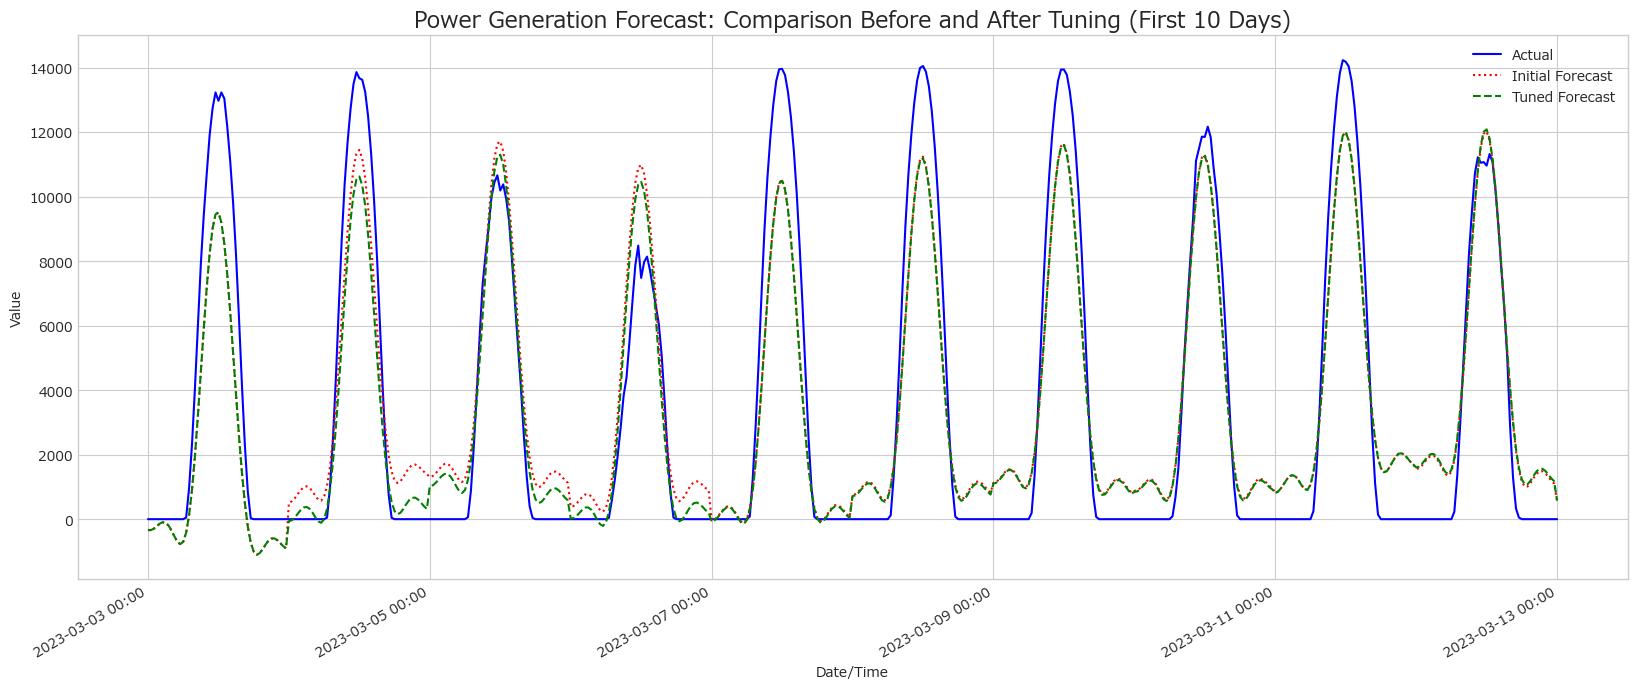

In [13]:
# Execute 30-day sliding window forecast with optimal parameters
print("Re-running 30-day power generation forecast using Optuna-tuned parameters...")
tuned_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True,
    **best_params_gen
}

# Re-forecast consumption with tuned parameters
preds_df_gen_tuned, _, _ = sliding_window_forecast(
    data=df,
    y_col='solar_gen_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=tuned_model_params
)
print("Done.")

# Comparison of evaluation metrics (30-day total) 
y_train_gen = df['solar_gen_mw'].iloc[:TRAIN_LENGTH]
metrics_gen_tuned = evaluate_forecast(preds_df_gen_tuned['true'], preds_df_gen_tuned['pred'], y_train_gen.values, m=48)

print("Comparison of evaluation metrics (Power Generation Forecast - 30 Days)")
comparison_gen_df = pd.DataFrame({
    'Initial': metrics_gen,
    'Tuned': metrics_gen_tuned
})
print(comparison_gen_df)

# Function definition for visualization
# Modified from src.plot_utils plot_forecast_vs_actual to display original series, pre-tuning, and post-tuning
def plot_tuned_forecast(initial_df, tuned_df, title, days_to_show=10):
    plt.figure(figsize=(20, 8))
    
    # Determine the period to display
    start_date = initial_df.index.min()
    end_date = start_date + pd.Timedelta(days=days_to_show)
    
    plot_data_initial = initial_df.loc[start_date:end_date]
    plot_data_tuned = tuned_df.loc[start_date:end_date]

    # Plot actual values
    plt.plot(plot_data_initial.index, plot_data_initial['true'], label='Actual', color='blue')

    # Plot pre-tuning forecast values
    plt.plot(plot_data_initial.index, plot_data_initial['pred'], color='red', linestyle=':', label='Initial Forecast')

    # Plot post-tuning forecast values
    plt.plot(plot_data_tuned.index, plot_data_tuned['pred'], color='green', linestyle='--', label='Tuned Forecast')

    plt.title(title, fontsize=16)
    plt.xlabel('Date/Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.show()

# Execute visualization (first 10 days)
plot_tuned_forecast(preds_df_gen, preds_df_gen_tuned, 'Power Generation Forecast: Comparison Before and After Tuning (First 10 Days)', days_to_show=10)

**Comparison Table**
```
Comparison of evaluation metrics (Power Generation Forecast - 30 Days)
          Initial        Tuned
MAE   1772.373970  1730.195857
RMSE  2436.543373  2446.802209
MASE     2.408882     2.351556
```

### 5-3-3. Consumption Prediction Tuning

In [14]:
# Define Optuna objective function
# Fix the data for tuning (first 60 days = TRAIN_LENGTH)
tune_df_con = df[['e_demand_mw']].iloc[:TRAIN_LENGTH].reset_index()
tune_df_con.columns = ['ds', 'y']

def objective_con(trial):
    # Define the range of parameters to tune
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
        'daily_seasonality': True,
        'weekly_seasonality': True,
        'yearly_seasonality': True
    }
    
    # Define the model
    model = Prophet(**params)
    model.fit(tune_df_con)
    
    # Perform cross-validation within TRAIN_LENGTH
    df_cv = cross_validation(
        model,
        initial='48 days', # 48 days
        period=f'1 day',  # 1 day
        horizon=f'1 day', # 1 day
        disable_tqdm=True
    )
    
    # Evaluation (RMSE)
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]

# Execute optimization using Optuna
print("Starting Optuna hyperparameter tuning (consumption)...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_con = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study_con.optimize(objective_con, n_trials=30, show_progress_bar=False)

# Display results
print("\nOptuna Tuning Results (consumption)")
print(f"Number of trials: {len(study_con.trials)}")
print(f"Optimal parameters: {study_con.best_params}")
print(f"Minimum RMSE: {study_con.best_value}")

# Keep best_params for use in subsequent cells
best_params_con = study_con.best_params

Starting Optuna hyperparameter tuning (consumption)...


17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
17:51:47 - cmdstanpy - INFO - Chain [1] start processing
17:51:47 - cmdstanpy - INFO - Chain [1] done processing
17:51:48 - cmdstanpy - INFO - Chain [1] start processing
17:51:48 - cmdstanpy - INFO - Chain [1] done processing
17:51:48 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:51 - cmdstanpy - INFO - Chain [1] start processing
17:51:51 - cmdstanpy - INFO - Chain [1] done pro


Optuna Tuning Results (consumption)
Number of trials: 30
Optimal parameters: {'changepoint_prior_scale': 0.2922711681339094, 'seasonality_prior_scale': 0.45714120348138376}
Minimum RMSE: 2107.5020084468024


#### 5-3-4. Consumption Prediction and Evaluation using Tuned Model

Re-executing 30-day demand forecast using Optuna-tuned parameters...


Sliding Window:   0%|          | 0/30 [00:00<?, ?it/s]

18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:31 - cmdstanpy - INFO - Chain [1] done processing
18:00:31 - cmdstanpy - INFO - Chain [1] start processing
18:00:33 - cmdstanpy - INFO - Chain [1] done processing
18:00:34 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing
18:00:36 - cmdstanpy - INFO - Chain [1] start processing
18:00:39 - cmdstanpy - INFO - Chain [1] done processing
18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing
18:00:42 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:51 - cmdstanpy - INFO - Chain [1] done processing
18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1]

Done.
Comparison of evaluation metrics (Demand Forecast - 30 days)
          Initial        Tuned
MAE   2323.211371  2163.355933
RMSE  2888.244610  2753.314147
MASE     0.735676     0.685055


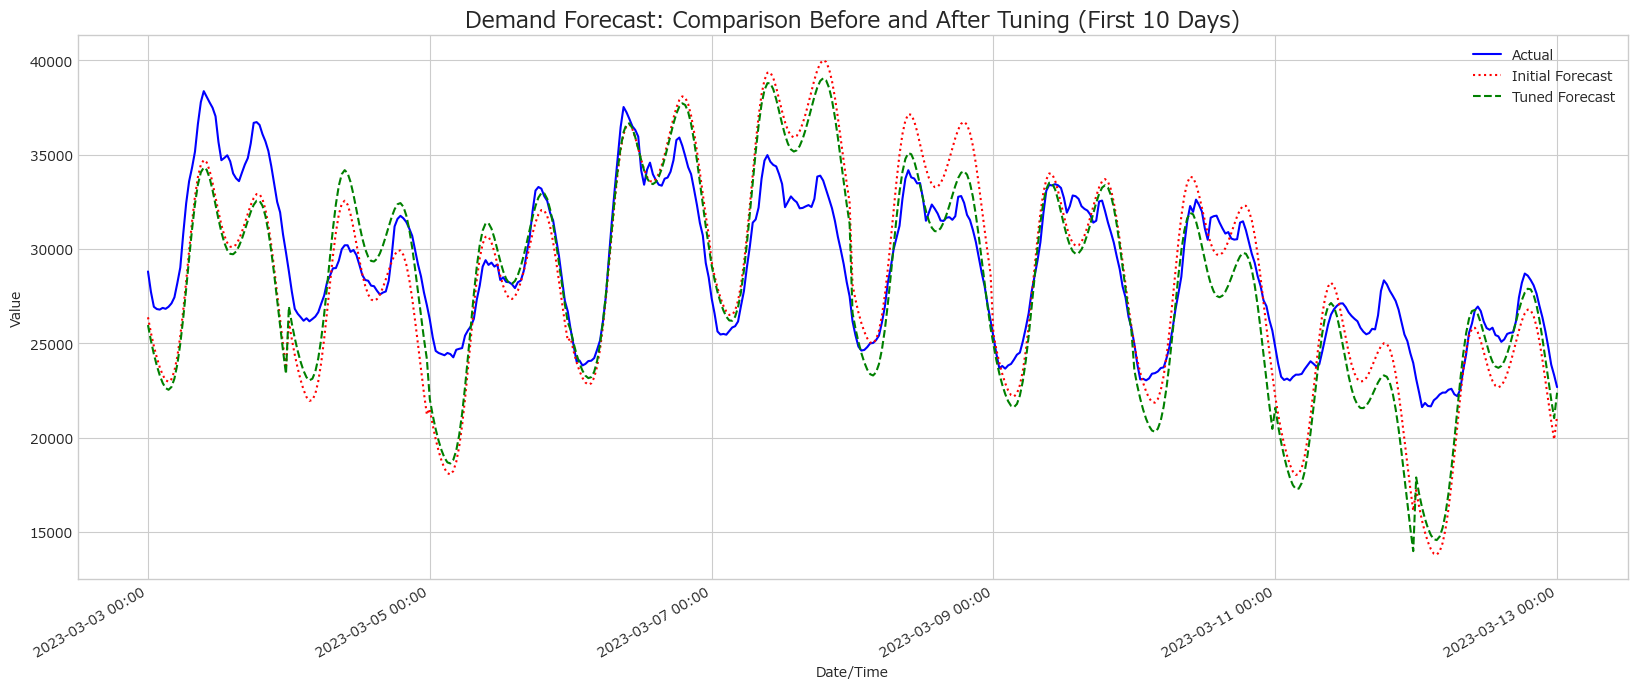

In [15]:
# Execute 30-day sliding window prediction with optimal parameters
print("Re-executing 30-day demand forecast using Optuna-tuned parameters...")
tuned_model_params = {
    'daily_seasonality': True,
    'weekly_seasonality': True,
    'yearly_seasonality': True,
    **best_params_con
}

# Re-forecast demand with tuned parameters
preds_df_con_tuned, _, _ = sliding_window_forecast(
    data=df,
    y_col='e_demand_mw',
    train_length=TRAIN_LENGTH,
    test_length=TEST_LENGTH,
    slide_count=SLIDE_COUNT,
    stride=STRIDE,
    model_func=prophet_model_wrapper,
    model_params=tuned_model_params
)
print("Done.")

# Comparison of evaluation metrics (overall 30 days)
y_train_con = df['e_demand_mw'].iloc[:TRAIN_LENGTH]
metrics_con_tuned = evaluate_forecast(preds_df_con_tuned['true'], preds_df_con_tuned['pred'], y_train_con.values, m=336)

print("Comparison of evaluation metrics (Demand Forecast - 30 days)")
comparison_demand_df = pd.DataFrame({
    'Initial': metrics_con,
    'Tuned': metrics_con_tuned
})
print(comparison_demand_df)

# Function definition for visualization
def plot_tuned_forecast(initial_df, tuned_df, title, days_to_show=10):
    plt.figure(figsize=(20, 8))
    
    # Determine the period to display
    start_date = initial_df.index.min()
    end_date = start_date + pd.Timedelta(days=days_to_show)
    
    plot_data_initial = initial_df.loc[start_date:end_date]
    plot_data_tuned = tuned_df.loc[start_date:end_date]

    # Plot actual values
    plt.plot(plot_data_initial.index, plot_data_initial['true'], label='Actual', color='blue')

    # Plot initial forecast values
    plt.plot(plot_data_initial.index, plot_data_initial['pred'], color='red', linestyle=':', label='Initial Forecast')

    # Plot tuned forecast values
    plt.plot(plot_data_tuned.index, plot_data_tuned['pred'], color='green', linestyle='--', label='Tuned Forecast')

    plt.title(title, fontsize=16)
    plt.xlabel('Date/Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate()
    plt.show()

# Execute visualization (first 10 days)
plot_tuned_forecast(preds_df_con, preds_df_con_tuned, 'Demand Forecast: Comparison Before and After Tuning (First 10 Days)', days_to_show=10)

**Comparison Table**
```
Comparison of evaluation metrics (Demand Forecast - 30 days)
          Initial        Tuned
MAE   2323.211371  2163.355933
RMSE  2888.244610  2753.314147
MASE     0.735676     0.685055
```

In [16]:
# Save results
# Assuming pred_df has 'true', 'pred' columns and a datetime index

# solar_gen_mw
preds_df_gen_tuned.to_pickle('../results/preds/solar_prophet.pkl')
print("Saved: ")

# e_demand_mw
preds_df_con_tuned.to_pickle('../results/preds/demand_prophet.pkl')
print("Saved: ")

Saved: 
Saved: 


### 5-4. Conclusion and Discussion

### 5-5-1. Accuracy Comparison Summary
| Eval. Index | **Generation** |  | **Consumption** |  |
| :--- | :---: | :---: | :---: | :---: |
| | Initial |  Tuned |  Initial  |  Tuned |
| MAE| 1772.37 | 1730.20 | 2323.21 | 2163.36 |
| RMSE | 2436.54 | 2446.80 | 2888.24 | 2753.31 |
| MASE| 2.409 |  2.352 |  0.736 |  0.685 |

### 5-5-2. Overall Summary
- **Overall Trend**: While slight accuracy improvements were observed for both power generation and consumption through parameter tuning, the extent of improvement was limited. It was not able to surpass the accuracy of Holt-Winters method or SARIMAX models.
- **Insights on Model Selection**:
    - Prophet's intuitive parameter settings and ease of adjusting seasonality and trends are major advantages. In particular, the decomposition plot was very useful for understanding the data structure.
    - However, in this task, no superiority in terms of accuracy was observed when compared to other baseline models. This suggests that the seasonal patterns (Fourier series) assumed by Prophet by default might not have fully captured the complex fluctuations inherent in electricity data.
    - For highly irregular data, such as solar power generation which only has values during specific times of the day (daytime), it is considered that more domain-knowledge-based customization (e.g., setting upper/lower bounds, adding custom seasonality) is necessary.

**Future Work:**
- Prophet is excellent for rapid analysis and interpretability, making it suitable for initial exploratory modeling. However, in pursuing prediction accuracy, an approach of adding insights gained from Prophet's decomposition (e.g., trend, seasonality) as features to machine learning models like LightGBM is presumed to be effective.
- For improvements to Prophet itself and accuracy enhancement measures, a table summarizing potential parameter tuning candidates was compiled, and countermeasures for the nighttime zero values in solar power generation were described below it.

**Future Outlook: Reference Information**
Tunable Parameters

This time, two main parameters were selected for tuning:
*   'changepoint_prior_scale' representing the flexibility of the trend.
*   'seasonality_prior_scale' representing the flexibility of the seasonal component.

In addition to these, there are many others as listed below, generally in order of decreasing frequency of use from top to bottom.

| Parameter Name                                                | Target                          | Typical Range/Value                            | Description/Role                                                                                                   |
|-------------------------------------------------------------|-----------------------------|------------------------------------------------|--------------------------------------------------------------------------------------------------------------------|
| **changepoint_prior_scale**                                 | Trend change (slope)        | 0.001 ~ 0.5 (default 0.05)                     | Most important parameter determining trend flexibility. Smaller values result in smoother/conservative trends; larger values allow sharp changes. Also carries the risk of overfitting. |
| **seasonality_prior_scale**                                 | Seasonality (overall)       | 1 ~ 20 (default 10)                            | How much fluctuation in the seasonal component is allowed. Too small will excessively suppress periodic patterns. |
| **holidays_prior_scale**                                    | Holiday effect              | 0.01 ~ 10 (default 10)                         | The intensity of the impact of holidays (or arbitrary events). Stronger values allow for greater reaction to events. |
| **seasonality_mode**                                        | Seasonality shape           | `'additive'` or `'multiplicative'`             | Treats seasonality as additive or multiplicative. `'multiplicative'` is advantageous for series with increasing trends. |
| **changepoint_range**                                       | Trend changepoint search range | 0.8 ~ 1.0 (default 0.8)                        | How much of the training period is considered for trend changepoints. Smaller values restrict it to only the early period. |
| **yearly_seasonality**                                      | Yearly seasonality          | True / False / int                             | Automatic detection or explicit specification (e.g., 10 -> 10 Fourier terms). Annual cycles (e.g., sales, temperature). |
| **weekly_seasonality**                                      | Weekly seasonality          | True / False / int                             | Data with weekly cycles (e.g., power consumption, traffic volume).                                                |
| **daily_seasonality**                                       | Daily seasonality           | True / False / int                             | Daily cycles (e.g., hourly data). Typically False for daily data.                                                  |
| **fourier_order** (accompanying yearly/weekly/daily_seasonality) | Decomposition precision for each seasonality | 3 ~ 20 (default: yearly=10, weekly=3, daily=10) | The order when expressing periodicity with sine waves. Higher orders express more detailed waveforms.           |
| **holidays**                                                | DataFrame (date, holiday columns) | Arbitrary                                      | Models specific date events (e.g., year-end, holidays) as exogenous effects.                                       |
| **growth**                                                  | Trend form                  | `'linear'` / `'logistic'`                      | Linear or logistic growth. Logistic requires setting a capacity upper bound (cap).                                 |
| **cap / floor**                                             | Trend upper/lower bounds    | Specified according to actual data             | Used only when `growth='logistic'`. Can reproduce upper-bound growth, etc.                                        |
| **n_changepoints**                                          | Number of candidate changepoints | 10 ~ 50 (default 25)                           | More changepoints offer greater flexibility but increase the risk of overfitting.                                  |
| **interval_width**                                          | Prediction interval width   | 0.8 ~ 0.95 (default 0.8)                       | Confidence level of the confidence interval. Important when calculating evaluation metrics.                        |
| **mcmc_samples**                                            | Bayesian estimation samples | 0 or numerical (e.g., 100~500)                 | For uncertainty evaluation. If 0, only MAP estimation. Note increased computational cost.                          |
| **uncertainty_samples**                                     | Samples for prediction intervals | Around 1000                                    | Precision of confidence intervals during `predict()`.                                                              |
| **add_seasonality(name, period, fourier_order, prior_scale)** | Custom seasonality          | Example: period=365.25/4, fourier_order=5      | Flexible setting to add arbitrary quarterly, biennial, etc., cycles.                                             |
| **add_regressor(name, prior_scale, standardize)**           | Exogenous variable          | Arbitrary                                      | Adds temperature, economic indicators, etc., as explanatory variables. Includes scaling control similar to LASSO. |

Example of seasonality setting from official GitHub:

```python
# Python
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)
```

**Future Outlook: Improvement Proposals for Solar Power Generation**

* Zero power generation during nighttime (after sunset, before sunrise) is poorly tracked.

1.  Restrict the `df` itself, feed it into the model, and then set predicted values to zero for the excluded time periods before returning.  
    (Fine annual variations in sunrise/sunset times may not be captured by using fixed time ranges.)

    ```python
    df_day = df[(df['ds'].dt.hour >= 5) & (df['ds'].dt.hour <= 18)]

    forecast = m.predict(future)
    forecast.loc[forecast['ds'].dt.hour < 5, 'yhat'] = 0
    forecast.loc[forecast['ds'].dt.hour > 18, 'yhat'] = 0
    ```

2.  Similar idea, but add daylight hours as an exogenous variable.  
    (Fine annual variations in sunrise/sunset times may not be captured by using fixed time ranges.)

    ```python
    df['daylight'] = ((df['ds'].dt.hour >= 5) & (df['ds'].dt.hour <= 18)).astype(int)

    m.add_regressor('daylight', mode='multiplicative')
    ```

3.  Obtain sunrise and sunset times using an astronomical library and add them as an exogenous variable.

    ```python
    from astral import LocationInfo
    from astral.sun import sun

    # timezone consideration is essential
    astral.sun.sun(Observer(location),date,**params)

    Returns: dict {"sunrise":, "sunset": ,}
    ```
    using functions such as the above.

    ```python
    df['sunlight_hours'] = df.apply(
        lambda row: int(sunrise <= row['ds'] <= sunset),
        axis=1
    )
    m.add_regressor('sunlight_hours', mode='multiplicative')
    ```

4.  Refine the Fourier waves for daily variation (auxiliary means, this alone will not make nighttime zero).

    ```python
    m = Prophet(daily_seasonality=False)

    m.add_seasonality(name='daily', period=24, fourier_order=6, prior_scale=5)
    ```